# Collect MusicLab recordings into device files
having now discovered several complications to the initial strategy for concatonating the minute long recordings of mobile accelerometer and gyroscope data, this new notebook should process the files efficiently from end to end.

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d

## Some essential functions

In [2]:
def appfileconcat(folder,file_suffix):
    # function to concatonate the one minute mobile sensor time series in files generated by MusicLab (0.0.17)
    #   files must be within a single folder, share a common suffix, that alphabetised file names ensures 
    #   chronological order (i.e. these files have submission IDs prepended), be immidiately readable by pandas read_csv
    #   (top row: column names, following rows only samples) and include a column titled "time" with device-consistent 
    #   timestampe values that continue accross files and in the same units as gap_t
    # This function uses libraries: os, pandas as pd, and local definition nannotime
    #
    # This function does not add nans in gaps, so interpolators beware. Pass any extracted file through gap_nans before resampling.
    #
    # Inputs:
    #   folder: string, relative path to the folder with the files to concatonate
    #   file_suffix: string, ending of file names for files to concatenate. ex: '.csv', 'deviceMotion.csv'
    #   inst_data: pandas dataframe containing all the samples across files, with inserted np.nan, in chronological order

    inst_data = pd.DataFrame()

    filenames = os.listdir(folder)
    filenames.sort() # files are processed in order set by sample index
    f_Count = 0
    # print(len(filenames))
    for fn in filenames:
        if fn.endswith(file_suffix):
        # if not begining, check for overlap
            if len(inst_data)>0:
                last_ts = inst_data.timestamp.max()
                tr = pd.read_csv(folder + '/' + fn)
                if tr.timestamp.min()<inst_data.timestamp.max():
                    tr = tr.loc[tr.timestamp>inst_data.timestamp.max(),:]
                    inst_data = pd.concat([inst_data,tr],ignore_index=True)
                else:
                    # add the files data to inst_data    
                    inst_data = pd.concat([inst_data,tr],ignore_index=True)
            else: 
                inst_data = pd.read_csv(folder + '/' + fn)
            f_Count +=1
    print( folder + ', ' + str(f_Count)) 
            
    cols = inst_data.columns
#     if 'time' in cols:
#         inst_data = inst_data.sort_values('time',ignore_index=True)
#         print('Time sorted')
#     else:
    inst_data = inst_data.sort_values('timestamp',ignore_index=True)
#         print('Timestamp sorted')
    # deal with the instances where time is not a monotonic sequence ??>?>?>?>
    if 'time' in inst_data.columns:
        if inst_data['time'].diff().min()<0:
            # replace time with floats 
            inst_data['time'] = inst_data['timestamp'] - inst_data.loc[0,'timestamp'] + inst_data.loc[0,'time']
        
    return inst_data

In [3]:
# note: these functions require any datetime feilds to be explicitely in pandas datatime formate.
# See examples of how to prep datetime columns in the usage examples below.

def nannotime(row,shift,dshift):
    # function to generate a row of nans with caveats for time fields, which are shifted by a designated ammount 
    r = row.copy()
    cols = r.index
    for c in cols:
        if not c.startswith('time'):
            if not c.startswith('datetime'):
                r[c] = np.nan
            if c.startswith('datetime'):
                r[c] = r[c] + dshift  
        if c.startswith('time'):
            r[c] = r[c] + shift     
    return r

def gap_nans(data,gap_t):
    # data is a pandas dataframe with columns called time and/or time_concert which is used to ID gaps greater than gap_T
    # rows of NaN data is added to non-time columns before the first sample, at edges of each gap, and after the last sample of data
    # these nans prevent interpolation errors through missing data
    cols = data.columns
    if 'time' in cols:
        time_col = 'time'
    if 'time_concert' in cols:
        time_col = 'time_concert'
    deltat = round(0.35*data[time_col].diff().median())
    dtdeltat =  pd.to_timedelta(deltat,unit = 'ms')
    
    data = data.append(nannotime(data.iloc[-1,:],deltat,dtdeltat),ignore_index=True)
    
    dt = data[time_col].diff()
    a = list(dt[dt>gap_t].index)
    a.sort(reverse=True)
    for gapi in a:
        data = data.append(nannotime(data.iloc[gapi-1,:],deltat,dtdeltat))
        data = data.append(nannotime(data.iloc[gapi,:],-deltat,dtdeltat))

    data = data.append(nannotime(data.iloc[0,:],-1,dtdeltat)).sort_values(time_col,ignore_index=True)
    return data

## test reading files from a single device
The MusicLab app generates uniquely named folders for each minute long recording of mobile sensors submitted to nettskjema. These have been downloaded and reorganised to have files for each device renamed and gathered into device specific folders, each named according to the installation ID randomly assigned to each device. (This ID string is unique but not identifying outside the musiclab app.) 

Details of this extraction process, from access the files via the Nettskjema API to reorganising them for more conveninent analysis, can be found in the repo https://github.com/finn42/PullingNettskjema

In [8]:
# windows machine data path
data_path = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/All'
instIDs = os.listdir(data_path)

C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/All/201c5bcf-081c-b8a2-2be3-f62ee4d10c78, 17


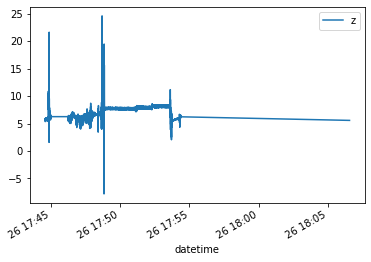

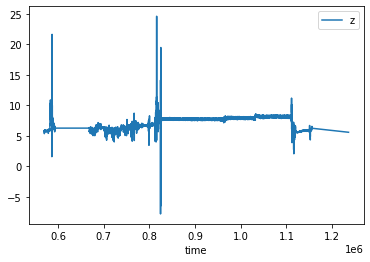

,timestamp,time,x,y,z,alpha,beta,gamma,datetime
0,1635270275438,569204.0,-0.1199,7.8599,5.7619,-3.6518,-1.1210,1.1750,2021-10-26 17:44:35.438
1,1635270275442,569209.0,-0.1199,7.8599,5.7619,-3.6518,-1.1210,1.1750,2021-10-26 17:44:35.442
2,1635270275456,569224.0,-0.1199,7.8599,5.7619,-3.6518,-1.1210,1.1750,2021-10-26 17:44:35.456
3,1635270275481,569248.0,-0.1199,7.8599,5.7619,-3.6518,-1.1210,1.1750,2021-10-26 17:44:35.481
4,1635270275488,569255.0,-0.1199,7.8599,5.7619,-3.6518,-1.1210,1.1750,2021-10-26 17:44:35.488
...,...,...,...,...,...,...,...,...,...
30192,1635270862752,1156535.0,0.8450,7.2594,6.3394,1.9533,5.2119,-0.7786,2021-10-26 17:54:22.752
30193,1635270862769,1156552.0,1.2884,7.1121,6.4833,0.5734,14.3687,1.2972,2021-10-26 17:54:22.769
30194,1635270862785,1156568.0,1.0687,7.0165,6.4923,7.9215,42.1251,4.0998,2021-10-26 17:54:22.785
30195,1635270862802,1156585.0,0.5372,7.3574,6.2212,8.9419,47.0159,5.8178,2021-10-26 17:54:22.802


In [10]:
# test reading a file
instid = "201c5bcf-081c-b8a2-2be3-f62ee4d10c78"

folder = data_path + '/' + instid
file_suffix = 'deviceMotion.csv'

# this function concatonates the dozens or hundreds of minute long recordings into single dataframe. It does this without 
inst_d = appfileconcat(folder,file_suffix) 
inst_d['datetime']=(pd.to_datetime(inst_d['timestamp'],unit='ms'))

# testing the 
inst_d.plot.line(x='datetime',y='z')
plt.show()
inst_d.plot.line(x='time',y='z')
plt.show()
inst_d

# Concatonate files for Remote dataset

In [12]:
data_path = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote'
output_folder = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Concated/Remote/deviceMotion/'
devices = os.listdir(data_path)

In [14]:
file_suffix = 'deviceMotion.csv'
for instid in devices:
    if len(instid)>10: # clearly an installation ID, not another folder
        folder = data_path + '/' + instid
        gap_t = 500 # ms 
        inst_d = appfileconcat(folder,file_suffix) 
        # printed is folder location for source files and the number of motion files concatonated 
        inst_d['datetime']=(pd.to_datetime(inst_d['timestamp'],unit='ms'))
        inst_d.to_csv(output_folder + instid + '_' + file_suffix, index = False)

C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/05d05a78-b18c-0928-cbf7-b5b1b9600e55, 161
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/06fad321-8a49-062e-1e84-26704be216b8, 242
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/08ff9d8a-6bc2-897f-24d3-91eb10717741, 1
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/090eb70c-5cc5-89d6-8f6c-14b2fdf7ab24, 1
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/09d8163d-80e7-fda3-6919-6a3febc78e27, 194
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/0af15a6c-6a42-89cf-9092-96de2a2553a5, 4
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/10550c8a-ad24-2550-6344-a0f8b85a4739, 66
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobil

C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/d7e89756-ada2-aed6-b3f7-716160c42fb9, 3
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/da8d357f-81d2-ead7-8de2-ae423b1b167e, 1
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/dba584ca-6587-4bc1-5165-4cf8e39eaaed, 4
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/ddfec0ee-dcc2-db2c-0de2-a22dfe78c044, 173
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/e630b096-5209-2a39-be53-e70d5042c429, 87
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/e6a57ce9-75de-1817-c8bb-87d42bea2a55, 171
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/ed274608-acbc-93a7-4aee-459c763ff762, 62
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile

There are many files in the remote dataset that have very few motion recordings. Most of these short recordings will not be retained in the aligned dataset as they do not contain a synchronisation cue.

In [15]:
data_path = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote'
output_folder = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Concated/Remote/geoLocation/'
devices = os.listdir(data_path)

In [16]:
devices = os.listdir(data_path)
file_suffix = 'geoLocation.csv'
geod = 0

for instid in devices:
    if len(instid)>10: # clearly an installation ID, not another folder
        folder = data_path + '/' + instid
        files = os.listdir(folder)
        if any(file_suffix in x for x in files):
            inst_d = appfileconcat(folder,file_suffix)
            # printed is folder location for source files and the number of motion files concatonated 

            # Reduce to minutes for anonymyzation
            inst_d['latitude'] = np.round(inst_d['latitude'])
            inst_d['longitude'] = np.round(inst_d['longitude'])
            inst_d = inst_d.drop(['accuracy'],axis=1)
            inst_d['datetime']=(pd.to_datetime(inst_d['timestamp'],unit='ms'))
            inst_d.to_csv(output_folder + instid + '_' + file_suffix, index = False)
            geod += 1
            
geod

C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/05d05a78-b18c-0928-cbf7-b5b1b9600e55, 6
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/06fad321-8a49-062e-1e84-26704be216b8, 116
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/090eb70c-5cc5-89d6-8f6c-14b2fdf7ab24, 1
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/09d8163d-80e7-fda3-6919-6a3febc78e27, 3
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/0af15a6c-6a42-89cf-9092-96de2a2553a5, 3
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/10550c8a-ad24-2550-6344-a0f8b85a4739, 66
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/1263f72c-512d-d97e-0fb1-561d37f92d7a, 4
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_da

C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/efaea337-9f55-a4cc-7aea-326524a54304, 59
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/f766dc4c-4363-5b99-678f-5e872b62da6a, 3
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/f77061cd-d9a2-8431-7e28-f35975330687, 198
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/fc4cf896-5278-020c-d4b3-d52d3d54630c, 7
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/fde2f9b4-7503-d799-0d3c-05b512b5b960, 7


69

Most remote participants allowed their location to be reported via the app, however half did not include enough movement data to be looked at in detail. Only a subset of the geoLocation files are usable for analysis of stream delays according to remote location. 



# Concatonate files for Hall dataset

In [17]:
data_path = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall'
output_folder = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Concated/Hall/deviceMotion/'
devices = os.listdir(data_path)

In [18]:
file_suffix = 'deviceMotion.csv'
for instid in devices:
    if len(instid)>10: # clearly an installation ID, not another folder
        folder = data_path + '/' + instid
        gap_t = 500 # ms 
        inst_d = appfileconcat(folder,file_suffix) 
        inst_d['datetime']=(pd.to_datetime(inst_d['timestamp'],unit='ms'))
        
        # a = part_trail_pull(inst_d,Start_time,End_time)
        inst_d.to_csv(output_folder + instid + '_' + file_suffix, index = False)

C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/005093c6-7880-8728-1256-26822f05cfb0, 255
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/01393de0-e72e-5e80-f06f-8fdb5d0080cb, 140
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/01d00c32-d4dc-8ce6-353c-43143401adf3, 147
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/03fcbb15-14c6-b806-80b8-e2c161654dd6, 94
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/04e20480-91d3-cd85-3470-8656b157978f, 138
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/053bd8a0-2ed7-46e9-c088-8eaea2448192, 150
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/0ab9bf2b-a0c7-f823-0fde-6295eedb207e, 122
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/C

C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/b71de359-9d19-b08d-ba92-85005358b1b9, 76
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/b75d0d85-7d79-3483-f0c5-890a1bf93e43, 18
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/bfc2274e-acb2-21af-16d5-6ae9fac1593e, 142
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/c32d3e7d-8ee6-0a11-b056-cb501edbfc7e, 127
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/cc1ce8ab-eee9-f8fe-177e-6c9721798373, 134
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/cd1ae6f8-b8cf-4a62-48a2-ff2590e4e4df, 72
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/cf163fcc-b07d-4b8c-09c2-bb67dfa35767, 113
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Con

Concert participants at the hall generally managed to share a large quantity of movement data, and most also included at least one interpretable tapping synchrony cue. 

In [19]:
data_path = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall'
output_folder = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Concated/Hall/geoLocation/'
devices = os.listdir(data_path)

In [20]:
devices = os.listdir(data_path)
file_suffix = 'geoLocation.csv'
geod = 0

for instid in devices:
    if len(instid)>10: # clearly an installation ID, not another folder
        folder = data_path + '/' + instid
        files = os.listdir(folder)
        if any(file_suffix in x for x in files):
            inst_d = appfileconcat(folder,file_suffix) 
            # Reduce to minutes for anonymyzation
            inst_d['latitude'] = np.round(inst_d['latitude'])
            inst_d['longitude'] = np.round(inst_d['longitude'])
            inst_d = inst_d.drop(['accuracy'],axis=1)
            inst_d['datetime']=(pd.to_datetime(inst_d['timestamp'],unit='ms'))
            inst_d.to_csv(output_folder + instid + '_' + file_suffix, index = False)
            geod += 1
            
geod

C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/005093c6-7880-8728-1256-26822f05cfb0, 1
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/01393de0-e72e-5e80-f06f-8fdb5d0080cb, 3
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/01d00c32-d4dc-8ce6-353c-43143401adf3, 1
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/03fcbb15-14c6-b806-80b8-e2c161654dd6, 3
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/053bd8a0-2ed7-46e9-c088-8eaea2448192, 147
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/0ab9bf2b-a0c7-f823-0fde-6295eedb207e, 1
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/195bb6e0-55ec-d521-d69e-7bfa7cf86b9a, 3
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_Musi

C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/f20847af-4c00-639e-5484-d705bd7a3437, 1
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/f6437dd9-96b3-7bce-42ef-4f01a6bfde18, 143
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/f9945bf5-e47a-a404-3f45-d6954e78ce2a, 1
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/fe0534f2-aaad-2afb-f5ba-79f8c2cc98b2, 1


69

The geoLocation data for the Hall participants is not very interesting, they were all in the same place supposedly and any differences in report will not survive the truncation of data. Many also refused to share their location in their mobile app permissions, though the anonymisation we perform would have still protected their privacy. This data may be of interest if anyone wants to check on regularly of app reporting under these circumstance.

# Check on alignment of data, without correction
We can get a quick snapshot of the movement data, get an overview of the texture and coverage, by interpolating to a shared time frame and extracting a simple feature like the normed motion. 

For this, we first define the timestamps for the final dataFrame, then we run through each set of deviceMotion files.

In [21]:
# set the sampling period for the concert in UTC 
Start_time = '2021-10-26 17:30:00+0000'
End_time = '2021-10-26 20:30:00+0000'
# set standard timestamps in date time and millisecond floats. Datetime for ploting, ms for interp
# 10 Hz
ts_dt = pd.date_range(pd.to_datetime(Start_time), pd.to_datetime(End_time), freq='100ms')
ts_ts = np.arange(pd.to_datetime(Start_time).timestamp(), pd.to_datetime(End_time).timestamp(), 0.1)*1000

In [22]:
# folder of devicewise files for a specific set
folder = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Concated/Hall/deviceMotion/'
devices = os.listdir(folder)

# prime dataframe and constants
aud_df = pd.DataFrame(index = ts_ts)
dev_n = 0
kept_dev = []
gap_t = 5000 # 5 seconds
file_suffix = 'deviceMotion.csv'

In [23]:
# gather the raw recordings for the live performance
for devFile in devices:
    if devFile.endswith(file_suffix): # clearly an installation ID, not another folder
        data = pd.read_csv(folder + '/' + devFile)
        data['datetime'] = (pd.to_datetime(data['timestamp'],unit='ms'))
        
        datas = gap_nans(data,gap_t)
        datas['datetime'] = (pd.to_datetime(datas['timestamp'],unit='ms'))
        
        resampled = pd.DataFrame(index = ts_dt[:-1])
        cols = datas.columns
        for col in cols[1:]:
            f = interpolate.interp1d(datas['timestamp'], datas[col],fill_value='extrapolate')
            resampled[col] = f(ts_ts)
            
        b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
        if np.nanmedian(b)>0:
            aud_df[dev_n] = b/np.nanmedian(b)
        else:
            aud_df[dev_n] = b/np.nanmean(b)
        dev_n+=1
        kept_dev.append(devFile)

aud_df.index = ts_dt[:-1]

hall_df = aud_df.copy()

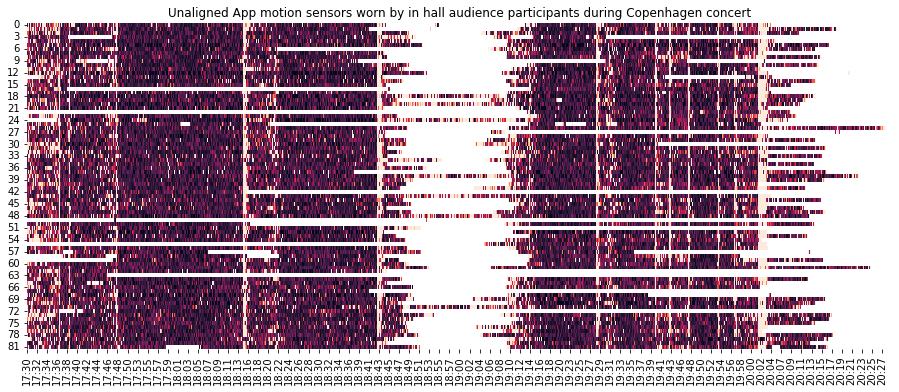

In [31]:
# plot for perspective
fig, ax = plt.subplots(figsize = [15.5,6])
chart = sns.heatmap(data=hall_df.transpose(), ax=ax,vmin=0, vmax=5,cbar=False)

freq = int(round(len(hall_df)/len(ax.get_xticks())))
ax.set_xticklabels(hall_df.iloc[::freq].index.strftime("%H:%M"))
plt.title('Unaligned App motion sensors worn by in hall audience participants during Copenhagen concert')
plt.savefig('./Plots/CoverageSnapshot_Copenhagen_Hall_raw.png')
plt.show()

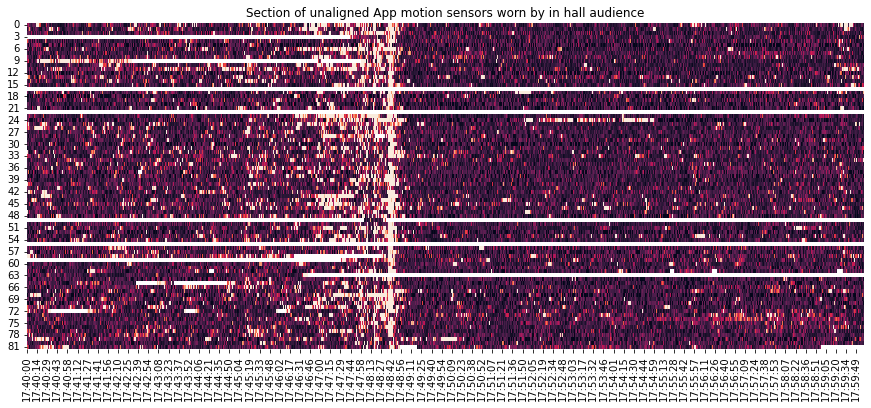

In [34]:
# TODO Make plot that zooms in so we can see the alignment quality
seg_df = hall_df.loc[ts_dt[6000]:ts_dt[18000]]
fig, ax = plt.subplots(figsize = [15,6])
chart = sns.heatmap(data=seg_df.transpose(), ax=ax,vmin=0, vmax=5,cbar=False)

freq = int(round(len(seg_df)/len(ax.get_xticks())))
ax.set_xticklabels(seg_df.iloc[::freq].index.strftime("%H:%M:%S"))
plt.title('Section of unaligned App motion sensors worn by in hall audience')
plt.savefig('./Plots/Coverage20MinSnapshot_Copenhagen_Hall_raw.png')
plt.show()

In [35]:
# folder of devicewise files for a specific set
folder = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Concated/Remote/deviceMotion/'
devices = os.listdir(folder)

# prime dataframe and constants
aud_df = pd.DataFrame(index = ts_ts)
dev_n = 0
kept_dev = []
gap_t = 5000 # 5 seconds
file_suffix = 'deviceMotion.csv'

In [36]:
# gather the raw recordings for the live performance
for devFile in devices:
    if devFile.endswith(file_suffix): # clearly an installation ID, not another folder
        data = pd.read_csv(folder + '/' + devFile)
        data['datetime'] = (pd.to_datetime(data['timestamp'],unit='ms'))
        datas = gap_nans(data,gap_t)
        datas['datetime'] = (pd.to_datetime(datas['timestamp'],unit='ms'))
        
        resampled = pd.DataFrame(index = ts_dt[:-1])
        cols = datas.columns
        for col in cols[1:]:
            f = interpolate.interp1d(datas['timestamp'], datas[col],fill_value='extrapolate')
            resampled[col] = f(ts_ts)
            
        b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
        if np.nanmedian(b)>0:
            aud_df[dev_n] = b/np.nanmedian(b)
        else:
            aud_df[dev_n] = b/np.nanmean(b)
        dev_n+=1
        kept_dev.append(devFile)

aud_df.index = ts_dt[:-1]

rem_df = aud_df.copy()

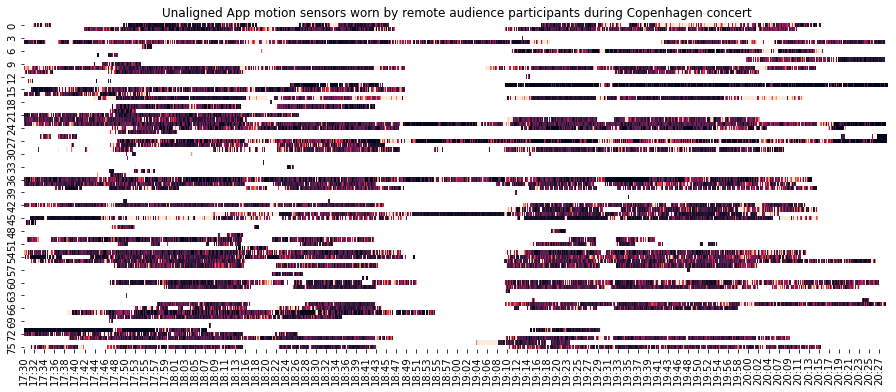

In [37]:
# plot for perspective
fig, ax = plt.subplots(figsize = [15.5,6])
chart = sns.heatmap(data=aud_df.transpose(), ax=ax,vmin=0, vmax=5,cbar=False)

freq = int(round(len(aud_df)/len(ax.get_xticks())))
ax.set_xticklabels(aud_df.iloc[::freq].index.strftime("%H:%M"))
plt.title('Unaligned App motion sensors worn by remote audience participants during Copenhagen concert')
plt.savefig('./Plots/CoverageSnapshot_Copenhagen_Remote_raw.png')
plt.show()

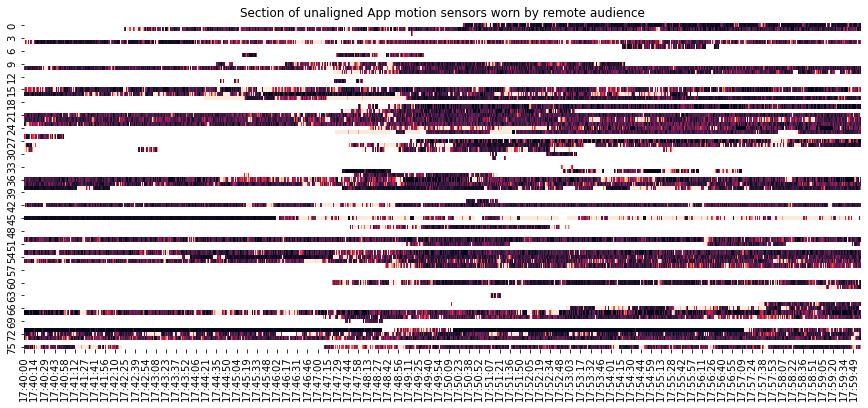

In [38]:
seg_df = rem_df.loc[ts_dt[6000]:ts_dt[18000]]
fig, ax = plt.subplots(figsize = [15,6])
chart = sns.heatmap(data=seg_df.transpose(), ax=ax,vmin=0, vmax=5,cbar=False)

freq = int(round(len(seg_df)/len(ax.get_xticks())))
ax.set_xticklabels(seg_df.iloc[::freq].index.strftime("%H:%M:%S"))
plt.title('Section of unaligned App motion sensors worn by remote audience')
plt.savefig('./Plots/Coverage20MinSnapshot_Copenhagen_Remote_raw.png')
plt.show()

In [47]:
aud_df = pd.concat([hall_df,rem_df],axis = 1)

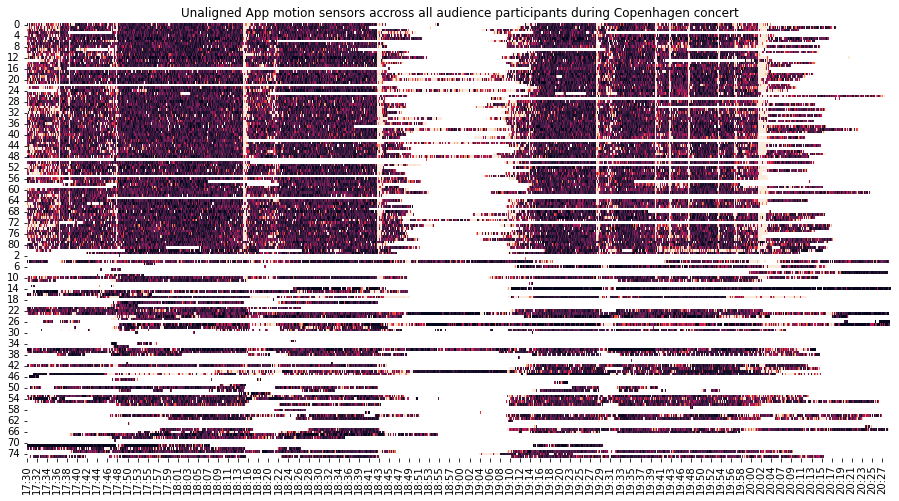

In [45]:
aud_df
fig, ax = plt.subplots(figsize = [15.5,8])
chart = sns.heatmap(data=aud_df.transpose(), ax=ax,vmin=0, vmax=5,cbar=False)

freq = int(round(len(aud_df)/len(ax.get_xticks())))
ax.set_xticklabels(aud_df.iloc[::freq].index.strftime("%H:%M"))
plt.title('Unaligned App motion sensors accross all audience participants during Copenhagen concert')
plt.savefig('./Plots/CoverageSnapshot_Copenhagen_All_raw.png')
plt.show()

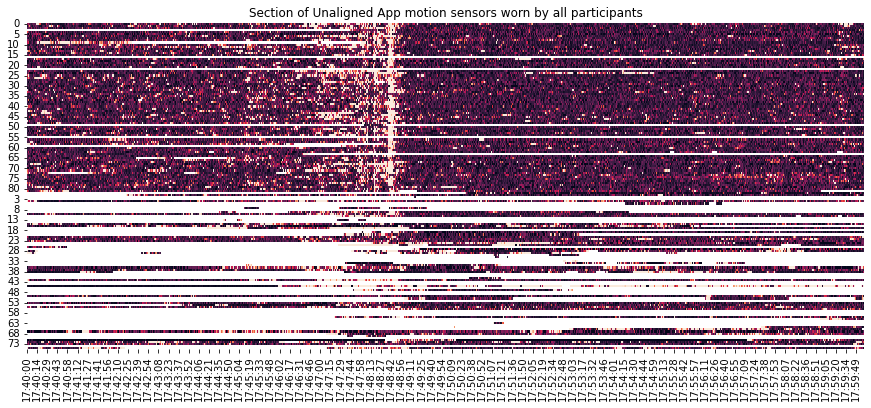

In [48]:
seg_df = aud_df.loc[ts_dt[6000]:ts_dt[18000]]
fig, ax = plt.subplots(figsize = [15,6])
chart = sns.heatmap(data=seg_df.transpose(), ax=ax,vmin=0, vmax=5,cbar=False)

freq = int(round(len(seg_df)/len(ax.get_xticks())))
ax.set_xticklabels(seg_df.iloc[::freq].index.strftime("%H:%M:%S"))
plt.title('Section of Unaligned App motion sensors worn by all participants')
plt.savefig('./Plots/Coverage20MinSnapshot_Copenhagen_All_raw.png')
plt.show()